# Travel Insurance Claims Prediction

(Created using Google Colaboratory)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import shap

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import *
from imblearn.under_sampling import *
from bayes_opt import BayesianOptimization
from xgboost import plot_importance

### Load Travel Insurance Dataset

In [5]:
travel_df = pd.read_csv('https://raw.githubusercontent.com/matthewfarant/masa_hackathon_2022/main/travel_insurance_dataset.csv?token=GHSAT0AAAAAABWYHOFPCIHMEPKWY7EJNSTCYXXN3SA')

In [6]:
travel_df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41


### Auto EDA using Pandas Profiling

In [ ]:
prof = ProfileReport(travel_df)
prof.to_file(output_file='travel_eda.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 168.37it/s]


### Feature Engineering

In [7]:
def feature_engineering(df):
    df.loc[df['Age']>100,'Age'] = np.NaN 
    df = pd.get_dummies(df,drop_first=True)
    col = df.columns
    imputer = KNNImputer(n_neighbors=2)
    df = pd.DataFrame(imputer.fit_transform(df))
    df.columns = col
    return df

cleaned_df = feature_engineering(travel_df)

### Data Splitting

In [17]:
def data_splitting(df,target_col,test_size):
    global X, y, X_train, X_test, y_train, y_test
    X = df.loc[:, df.columns != target_col]
    y = df.loc[:, target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 0)

data_splitting(cleaned_df,'Claim_Yes',0.3)

### Imbalanced Data: Claim vs. No Claim

In [ ]:
# 0 = No Claim
# 1 = Claim
cleaned_df['Claim_Yes'].value_counts()

0.0    62399
1.0      927
Name: Claim_Yes, dtype: int64

Comparison of Oversampling & Undersampling Methods using XGBoost ROC-AUC

In [ ]:
model = xgb.XGBRFClassifier(random_state=100)

In [ ]:
# some oversampling methods
over_methods = [
    SMOTE(random_state=100),
    BorderlineSMOTE(random_state=100),
    SVMSMOTE(random_state=100)
]
# cross validation (oversampling)
for methods in over_methods:
  X_train_res, y_train_res = methods.fit_resample(X_train, y_train.ravel())
  score = cross_val_score(model, X_train_res, y_train_res, cv=5, scoring="roc_auc", n_jobs=-1)
  print("The XGB ROC-AUC Mean Score for ",methods," is ",np.mean(score))

The XGB ROC-AUC Mean Score for  SMOTE(random_state=100)  is  0.9137785571469423
The XGB ROC-AUC Mean Score for  BorderlineSMOTE(random_state=100)  is  0.9515687439601501
The XGB ROC-AUC Mean Score for  SVMSMOTE(random_state=100)  is  0.9415471152057411


In [ ]:
# some undersampling methods
under_methods = [
    RandomUnderSampler(random_state=100),
    NearMiss(),
    EditedNearestNeighbours()
]
# cross validation (undersampling)
for methods in under_methods:
  X_train_res, y_train_res = methods.fit_resample(X_train, y_train.ravel())
  score = cross_val_score(model, X_train_res, y_train_res, cv=5, scoring="roc_auc", n_jobs=-1)
  print("The XGB ROC-AUC Mean Score for ",methods," is ",np.mean(score))

The XGB ROC-AUC Mean Score for  RandomUnderSampler(random_state=100)  is  0.8783143306705398
The XGB ROC-AUC Mean Score for  NearMiss()  is  0.8139634874525942
The XGB ROC-AUC Mean Score for  EditedNearestNeighbours()  is  0.7767297528225076


In [9]:
# (Based on above examination)

# Best oversampling
bsm = BorderlineSMOTE(random_state=100)
X_train_res_bsm, y_train_res_bsm = bsm.fit_resample(X_train, y_train.ravel())

# Best undersampling
rus = RandomUnderSampler(random_state=100)
X_train_res_rus, y_train_res_rus = rus.fit_resample(X_train, y_train.ravel())

### Hyperparameter Tuning using Bayesian Optimization

In [10]:
# Hyperparameter Space
hps = {
  'min_child_weight':(3, 20),
  'gamma':(0, 10),
  'subsample':(0.5, 1),
  'colsample_bytree':(0.1, 1),
  'max_depth': (2, 20),
  'learning_rate': (0, 1)
}

def hyper_xgboost(max_depth, subsample, colsample_bytree,min_child_weight, gamma, learning_rate):
    params = {
    'objective': 'binary:logistic',
    'eval_metric':'auc',
    'nthread':-1
     }
    params['max_depth'] = int(round(max_depth))
    params['subsample'] = max(min(subsample, 1), 0)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['min_child_weight'] = int(min_child_weight)
    params['gamma'] = max(gamma, 0)
    params['learning_rate'] = learning_rate
    scores = xgb.cv(params, dtrain, num_boost_round=500,verbose_eval=False,   #XGBoost requires data to be transformed into DMatrix
                    early_stopping_rounds=10, nfold=3)
    return scores['test-auc-mean'].iloc[-1]

In [ ]:
# BorderlineSMOTE
dtrain = xgb.DMatrix(X_train_res_bsm, y_train_res_bsm, feature_names=X_train_res_bsm.columns.values)
optimizer = BayesianOptimization(hyper_xgboost, hps, random_state=1)
optimizer.maximize(init_points=2, n_iter=5)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.9807   |  0.4753   |  7.203    |  0.000114 |  7.442    |  5.495    |  0.5462   |
|  2        |  0.9973   |  0.2676   |  3.456    |  0.3968   |  11.7     |  10.13    |  0.8426   |
|  3        |  0.997    |  0.2908   |  3.604    |  0.8477   |  11.16    |  10.07    |  0.6585   |
|  4        |  0.9967   |  0.137    |  0.04274  |  1.0      |  11.77    |  15.54    |  0.5      |
|  5        |  0.9968   |  1.0      |  6.52     |  1.0      |  16.83    |  15.5     |  0.5      |
|  6        |  0.9966   |  1.0      |  0.0      |  1.0      |  19.6     |  10.26    |  0.5      |
|  7        |  0.9968   |  1.0      |  0.0      |  1.0      |  20.0     |  20.0     |  0.5253   |


In [ ]:
optimizer.max['params']

{'colsample_bytree': 0.2676341902399038,
 'gamma': 3.4556072704304777,
 'learning_rate': 0.39676747423066994,
 'max_depth': 11.698701212060424,
 'min_child_weight': 10.126306744856013,
 'subsample': 0.8426097501983798}

In [ ]:
# Based on the best parameter tuning above
params = {
    'colsample_bytree': 0.2676341902399038,
    'gamma': 3.4556072704304777,
    'learning_rate': 0.39676747423066994,
    'max_depth': 12,
    'min_child_weight': 10,
    'subsample': 0.8426097501983798,
    'objective': 'binary:logistic',
    'eval_metric':'auc',
    'n_jobs':-1
}
xgbr =  xgb.XGBClassifier(**params, random_state=12345, nthread=-1)
xgbr.fit(X_train_res_bsm, y_train_res_bsm)

XGBClassifier(colsample_bytree=0.2676341902399038, eval_metric='auc',
              gamma=3.4556072704304777, learning_rate=0.39676747423066994,
              max_depth=12, min_child_weight=10, n_jobs=-1, nthread=-1,
              random_state=12345, subsample=0.8426097501983798)

In [ ]:
y_pred = xgbr.predict(X_test)
testing_accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test,y_pred)
print("Test Accuracy score {0}".format(testing_accuracy))
print("ROC AUC Score {0}".format(roc_auc))
print(classification_report(y_test, y_pred))

Test Accuracy score 0.9807874513106642
ROC AUC Score 0.5324529549818647
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     18748
         1.0       0.12      0.07      0.09       250

    accuracy                           0.98     18998
   macro avg       0.55      0.53      0.54     18998
weighted avg       0.98      0.98      0.98     18998



In [11]:
# RandomUnderSampling
dtrain = xgb.DMatrix(X_train_res_rus, y_train_res_rus, feature_names=X_train_res_rus.columns.values)
optimizer = BayesianOptimization(hyper_xgboost, hps, random_state=1)
optimizer.maximize(init_points=2, n_iter=5)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.813    |  0.4753   |  7.203    |  0.000114 |  7.442    |  5.495    |  0.5462   |
|  2        |  0.8033   |  0.2676   |  3.456    |  0.3968   |  11.7     |  10.13    |  0.8426   |
|  3        |  0.8134   |  0.4054   |  7.817    |  0.1203   |  7.538    |  5.589    |  0.9949   |
|  4        |  0.8019   |  0.9503   |  10.0     |  0.9178   |  2.175    |  3.0      |  1.0      |
|  5        |  0.5      |  0.1      |  8.611    |  0.0      |  10.69    |  3.29     |  0.5      |
|  6        |  0.8078   |  0.725    |  7.932    |  0.4388   |  4.237    |  6.484    |  1.0      |
|  7        |  0.8088   |  0.4047   |  6.405    |  0.3202   |  7.343    |  9.396    |  1.0      |


In [12]:
optimizer.max['params']

{'colsample_bytree': 0.40544442522369606,
 'gamma': 7.817083262953675,
 'learning_rate': 0.12026101657458521,
 'max_depth': 7.5375584166706435,
 'min_child_weight': 5.588844458037286,
 'subsample': 0.9948819242832455}

In [13]:
# Based on the best parameter tuning above
params = {
    'colsample_bytree': 0.40544442522369606,
    'gamma': 7.817083262953675,
    'learning_rate': 0.12026101657458521,
    'max_depth': 8,
    'min_child_weight': 6,
    'subsample': 0.9948819242832455,
    'objective': 'binary:logistic',
    'eval_metric':'auc',
    'n_jobs':-1
}
xgbr =  xgb.XGBClassifier(**params, random_state=12345, nthread=-1)
xgbr.fit(X_train_res_rus, y_train_res_rus)

XGBClassifier(colsample_bytree=0.40544442522369606, eval_metric='auc',
              gamma=7.817083262953675, learning_rate=0.12026101657458521,
              max_depth=8, min_child_weight=6, n_jobs=-1, nthread=-1,
              random_state=12345, subsample=0.9948819242832455)

In [14]:
y_pred = xgbr.predict(X_test)
testing_accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test,y_pred)
print("Test Accuracy score {0}".format(testing_accuracy))
print("ROC AUC Score {0}".format(roc_auc))
print(classification_report(y_test, y_pred))

Test Accuracy score 0.8275607958732498
ROC AUC Score 0.7271376146788991
              precision    recall  f1-score   support

         0.0       0.99      0.83      0.90     18748
         1.0       0.05      0.62      0.09       250

    accuracy                           0.83     18998
   macro avg       0.52      0.73      0.50     18998
weighted avg       0.98      0.83      0.89     18998



In [15]:
print(confusion_matrix(y_test,y_pred))

[[15566  3182]
 [   94   156]]


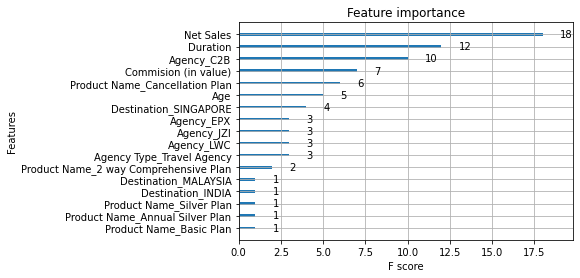

In [16]:
# XGBoost Feature Importance
plot_importance(xgbr)
plt.show()

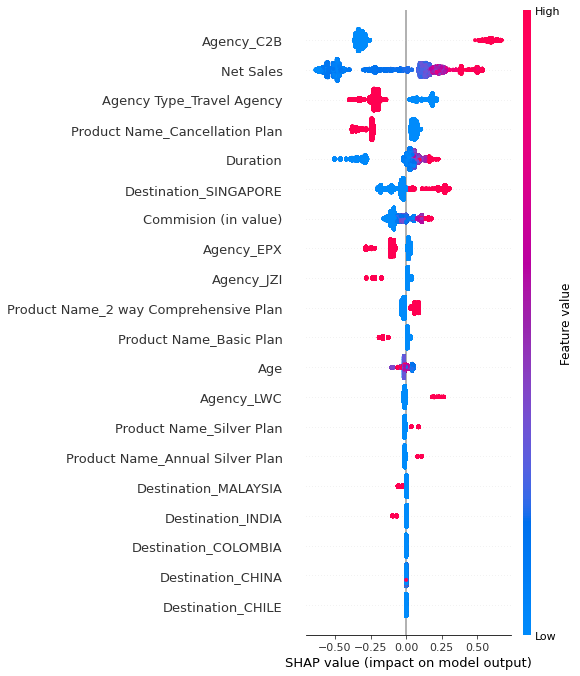

In [19]:
shap_values = shap.TreeExplainer(xgbr).shap_values(X)
shap.summary_plot(shap_values, X)